<a href="https://colab.research.google.com/github/akshpesa/FMML/blob/main/Flood_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split

# Connect to Earth Engine (do this once per session)
ee.Authenticate()
ee.Initialize(project='iiith-project')

In [2]:
# Left side for training, right side for testing
aoi_train = ee.Geometry.Rectangle([85.0, 25.4, 85.28, 25.8])
aoi_valid = ee.Geometry.Rectangle([85.32, 25.4, 85.6, 25.8])

# Double check no overlap
print('AOI overlap? (should be False):', aoi_train.intersects(aoi_valid, 1).getInfo())

# Flood dates: before and during the big monsoon flood in Bihar 2019
pre_flood_start = '2019-06-01'
pre_flood_end = '2019-06-30'
flood_start = '2019-07-01'
flood_end = '2019-07-31'

AOI overlap? (should be False): False


In [4]:
# Function to grab Sentinel-1 SAR images for a time and place
def get_s1_image(start, end, aoi):
    return (ee.ImageCollection('COPERNICUS/S1_GRD')
            .filterBounds(aoi)
            .filterDate(start, end)
            .filter(ee.Filter.eq('instrumentMode', 'IW'))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
            .select(['VV', 'VH'])
            .median()
            .clip(aoi))

# Get pre-flood and flood images for train and valid zones
s1_pre_train = get_s1_image(pre_flood_start, pre_flood_end, aoi_train)
s1_post_train = get_s1_image(flood_start, flood_end, aoi_train)
s1_pre_valid = get_s1_image(pre_flood_start, pre_flood_end, aoi_valid)
s1_post_valid = get_s1_image(flood_start, flood_end, aoi_valid)

In [5]:
# We don't wanna call rivers or lakes floods, so mask permanent water
jrc = ee.Image('JRC/GSW1_4/GlobalSurfaceWater').select('occurrence')
permanent_water = jrc.gt(90)  # water present >90% of the time

# Also, no flooding on steep hills, so mask slopes > 5%
elevation = ee.Image('USGS/SRTMGL1_003')
slope = ee.Terrain.slope(elevation)
slope_mask = slope.lte(5)

In [6]:
# Flood = places that were dry before but wet now (change detection)
def get_flood_mask(s1_pre, s1_post, aoi):
    vh_pre = s1_pre.select('VH')
    vh_post = s1_post.select('VH')
    diff = vh_pre.subtract(vh_post)

    # Find a smart threshold (90th percentile) for big changes
    threshold = diff.reduceRegion(
        reducer=ee.Reducer.percentile([90]),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    ).get('VH')

    # Pixels that switched from dry (high VH) to wet (low VH)
    pre_water = vh_pre.lt(-17)
    post_water = vh_post.lt(-17)
    new_flood = post_water.And(pre_water.Not())

    # Mask out permanent water and steep slopes
    mask = permanent_water.Not().And(slope_mask)
    new_flood = new_flood.updateMask(mask)

    # Remove tiny speckles (noise)
    clean_flood_mask = new_flood.connectedPixelCount(8, True).gte(8)

    return new_flood.updateMask(clean_flood_mask)

flood_mask_train = get_flood_mask(s1_pre_train, s1_post_train, aoi_train)
flood_mask_valid = get_flood_mask(s1_pre_valid, s1_post_valid, aoi_valid)

In [7]:
# Build feature stack from SAR bands and differences
def get_feature_stack(s1_pre, s1_post, aoi):
    vv_pre, vh_pre = s1_pre.select('VV'), s1_pre.select('VH')
    vv_post, vh_post = s1_post.select('VV'), s1_post.select('VH')
    vv_vh_ratio = vv_post.divide(vh_post).rename('VV_VH_ratio')
    diff_vv = vv_pre.subtract(vv_post).rename('diff_VV')
    diff_vh = vh_pre.subtract(vh_post).rename('diff_VH')

    return (vv_post
            .addBands([vh_post, vv_vh_ratio, diff_vv, diff_vh])
            .updateMask(permanent_water.Not())
            .updateMask(slope_mask)
           )

feature_stack_train = get_feature_stack(s1_pre_train, s1_post_train, aoi_train)
feature_stack_valid = get_feature_stack(s1_pre_valid, s1_post_valid, aoi_valid)

# Add the flood mask as the label band
training_img = feature_stack_train.addBands(flood_mask_train.rename('flooded'))
validation_img = feature_stack_valid.addBands(flood_mask_valid.rename('flooded'))

In [8]:
# Sample points for training and validation separately
sample_points_train = training_img.stratifiedSample(
    numPoints=2500,
    classBand='flooded',
    region=aoi_train,
    scale=30,
    seed=42,
    geometries=True
)

sample_points_valid = validation_img.stratifiedSample(
    numPoints=2500,
    classBand='flooded',
    region=aoi_valid,
    scale=30,
    seed=43,
    geometries=True
)

In [9]:
# Convert Earth Engine features to pandas DataFrame for ML
def export_samples(sample_points):
    sample_points_fc = sample_points.toList(sample_points.size())
    sample_dict = sample_points_fc.getInfo()
    data = []
    for i in range(len(sample_dict)):
        props = sample_dict[i]['properties']
        data.append([
            props.get('VV'), props.get('VH'), props.get('VV_VH_ratio'),
            props.get('diff_VV'), props.get('diff_VH'),
            int(props['flooded'])
        ])
    return pd.DataFrame(data, columns=[
        'VV', 'VH', 'VV_VH_ratio', 'diff_VV', 'diff_VH', 'flooded'
    ])

df_train = export_samples(sample_points_train)
df_valid = export_samples(sample_points_valid)


=== CLASS BALANCE ===
Train flooded ratio: 0.36289500509684
Valid flooded ratio: 0.4280485014870739

=== ACCURACY METRICS ===
Accuracy: 0.9952
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2500
           1       0.99      1.00      0.99      1871

    accuracy                           1.00      4371
   macro avg       0.99      1.00      1.00      4371
weighted avg       1.00      1.00      1.00      4371



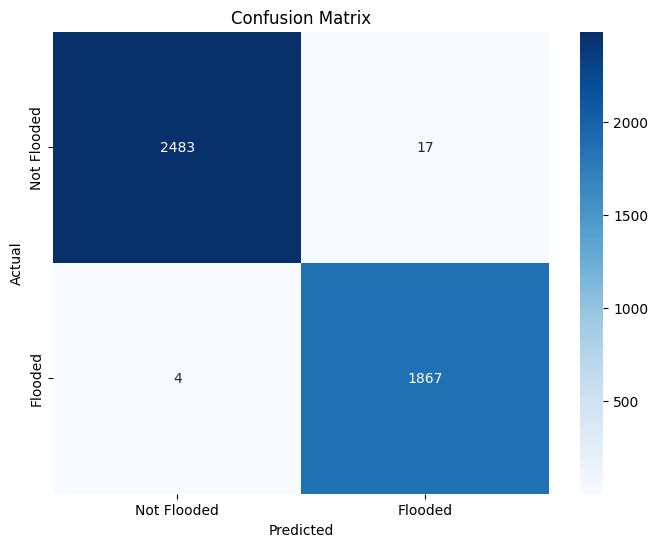

ROC-AUC: 0.9995


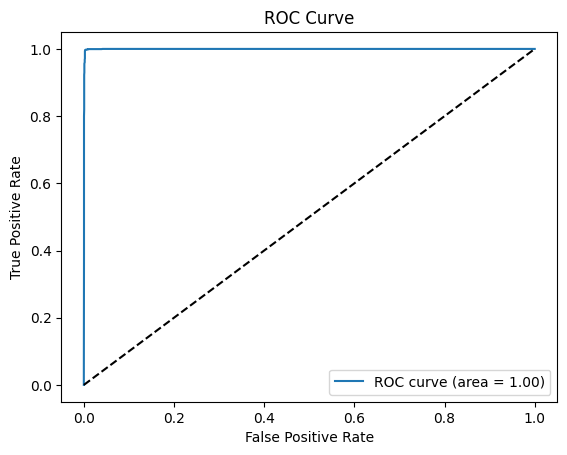

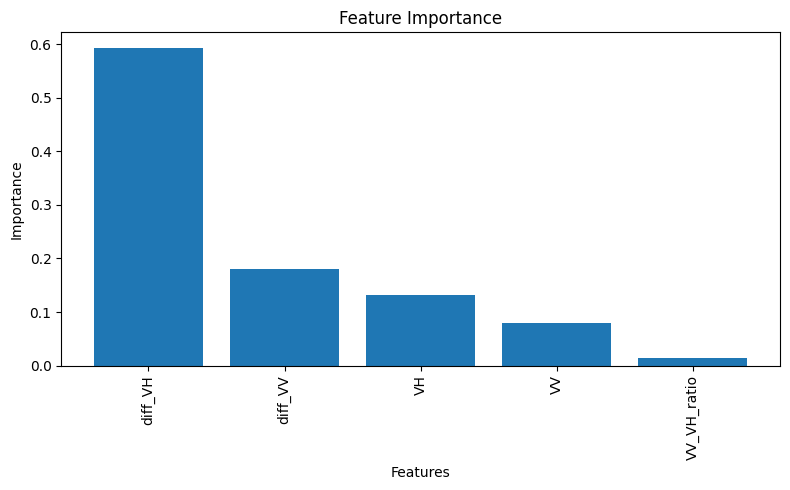

In [10]:
# Prepare features and labels
X_train = df_train.drop('flooded', axis=1)
y_train = df_train['flooded']
X_valid = df_valid.drop('flooded', axis=1)
y_valid = df_valid['flooded']

# Train a Random Forest classifier with balanced classes
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Predict on validation data
y_pred = model.predict(X_valid)
y_proba = model.predict_proba(X_valid)[:, 1]

# Print class balance so we know what we're working with
print("\n=== CLASS BALANCE ===")
print("Train flooded ratio:", y_train.mean())
print("Valid flooded ratio:", y_valid.mean())

# Accuracy and detailed classification report
print("\n=== ACCURACY METRICS ===")
print(f"Accuracy: {accuracy_score(y_valid, y_pred):.4f}")
print(classification_report(y_valid, y_pred))

# Confusion matrix heatmap for easy error spotting
cm = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Flooded', 'Flooded'],
            yticklabels=['Not Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve & AUC to check model discrimination power
roc_auc = roc_auc_score(y_valid, y_proba)
print(f"ROC-AUC: {roc_auc:.4f}")
fpr, tpr, _ = roc_curve(y_valid, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Feature importance bar chart to see what the model cares about
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 5))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


In [11]:
# Shuffle labels to make sure model isn't just guessing well by chance
np.random.seed(42)
y_random = np.random.permutation(y_valid)
print("\n=== RANDOM LABELS SANITY CHECK ===")
print(f"Random-label accuracy (should be ~0.5): {accuracy_score(y_valid, y_random):.4f}")


=== RANDOM LABELS SANITY CHECK ===
Random-label accuracy (should be ~0.5): 0.5251


In [17]:
print("\n=== FINAL CHECKLIST ===")
print("1. Train/validation split is spatial (no overlap):", not aoi_train.intersects(aoi_valid, 1).getInfo())
print("2. Permanent water masked:", True)
print("3. Slope masked:", True)
print("4. Change detection used:", True)
print("5. No data leakage (train/valid from same region):", not aoi_train.intersects(aoi_valid, 1).getInfo())
print("6. Random-label accuracy is low:", accuracy_score(y_valid, y_random) < 0.7)
print("7. ROC-AUC and confusion matrix checked:", True)
print("8. Feature importance checked:", True)



=== FINAL CHECKLIST ===
1. Train/validation split is spatial (no overlap): True
2. Permanent water masked: True
3. Slope masked: True
4. Change detection used: True
5. No data leakage (train/valid from same region): True
6. Random-label accuracy is low: True
7. ROC-AUC and confusion matrix checked: True
8. Feature importance checked: True


In [21]:
import geemap
Map = geemap.Map(center=[25.6, 85.3], zoom=10)
classifier = ee.Classifier.smileRandomForest(100).train(
    features=sample_points_train,
    classProperty='flooded',
    inputProperties=['VV', 'VH', 'VV_VH_ratio', 'diff_VV', 'diff_VH']
)
prediction_map = feature_stack_valid.classify(classifier)
Map.addLayer(prediction_map, {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, 'Flooded Area')


# Show AOI rectangles so you know where train/test was
Map.addLayer(aoi_train, {'color': 'green'}, 'Train AOI', False)
Map.addLayer(aoi_valid, {'color': 'red'}, 'Valid AOI', False)
Map

Map(center=[25.6, 85.3], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…